<a href="https://colab.research.google.com/github/Nataly-nb/ds-projects/blob/main/Colab/Test_task_preg_risk_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Описание

**Задача**

Создать прогностическую модель рисков беременных.  
Срок: до 1 недели
Метрика: решаете сами
Как сдавать: ссылку на google colab с выводами. Обязательно вывести матрицу ошибок на тесте.
Особенности: В последних ячейках необходимо вывести метрики и матрицу ошибок на трейне и тесте.

Описание:

Age: Age in years when a woman is pregnant.  
SystolicBP: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.  
DiastolicBP: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.  
BS: Blood glucose levels is in terms of a molar concentration, mmol/L.  
HeartRate: A normal resting heart rate in beats per minute.  
Risk Level: Predicted Risk Intensity Level during pregnancy considering the previous attribute.  
  
  

Согласно описанию датасета, данные были собраны из различных больниц, общественных клиник и служб охраны материнского здоровья в сельских районах Бангладеш.
https://archive.ics.uci.edu/dataset/863/maternal+health+risk

#Загрузка данных, анализ и подготовка

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.4 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
RANDOM_STATE = 4132

In [ ]:
uploaded = files.upload()

Saving MaternalHealthRiskDataSet.csv to MaternalHealthRiskDataSet.csv


In [ ]:
df = pd.read_csv('MaternalHealthRiskDataSet.csv')

In [ ]:
display(df.shape)
display(df.info())

(1014, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


None

In [ ]:
display(df.head())
display(df.describe().T)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


Пустых значений нет, аномальные значения есть в пульсе и возможно в возрасте.
Risk Level является целевым признаком и категориальным, остальные - числовые признаки.




In [ ]:
df['RiskLevel'].unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [ ]:
print('Количество явных дубликатов:', df.duplicated().sum(), '\n')
print('Количество пропусков: \n', df.isna().sum().sort_values(ascending=False).head(5))

Количество явных дубликатов: 562 

Количество пропусков: 
 Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
dtype: int64


Дубликатов: 562 - больше половины строк. Пропусков нет. Посмотрим что это за дубликаты.

In [ ]:
df[df.duplicated()==True]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
67,19,120,80,7.0,98.0,70,mid risk
72,19,120,80,7.0,98.0,70,mid risk
97,19,120,80,7.0,98.0,70,mid risk
106,50,140,90,15.0,98.0,90,high risk
107,25,140,100,6.8,98.0,80,high risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


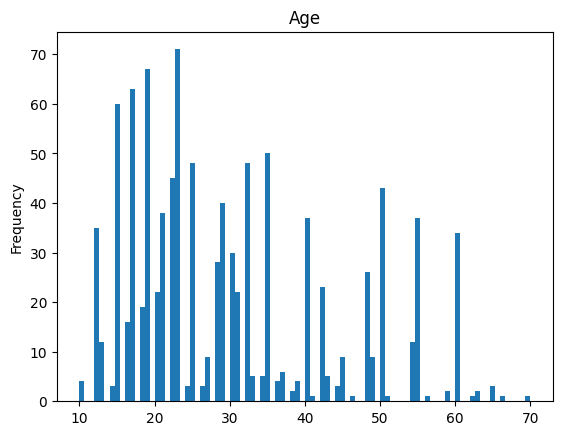

In [ ]:
df['Age'].plot(kind='hist', bins=90, title='Age');

Возраст старше 55 лет подозрителен, но такие случаи в практике встречаются, считать выбросами не нужно.

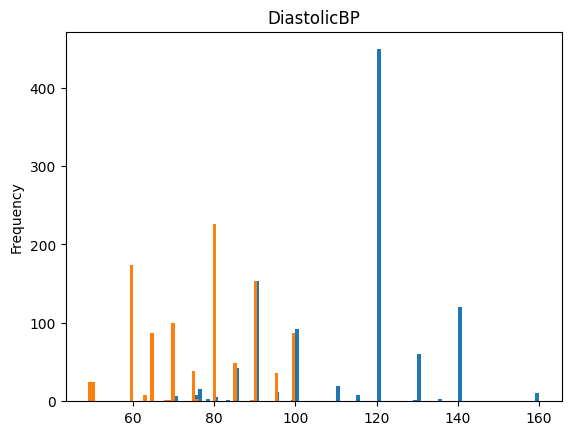

In [ ]:
df['SystolicBP'].plot(kind='hist', bins=90, title='SystolicBP');
df['DiastolicBP'].plot(kind='hist', bins=60, title='DiastolicBP');

Значения давления крайне дискретны.

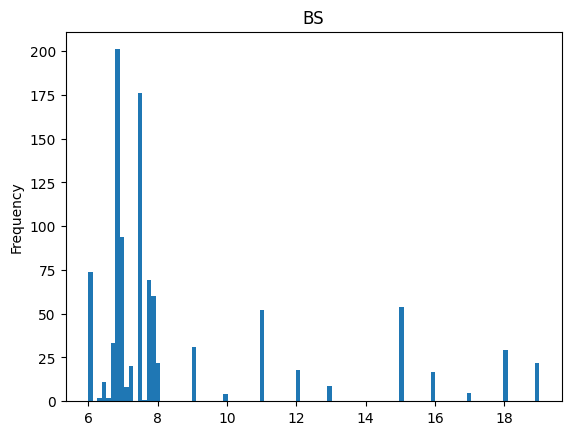

In [ ]:
df['BS'].plot(kind='hist', bins=100, title='BS');

Значение глюкозы от 7 до 20 - плохо, но, к сожалению, распространено.

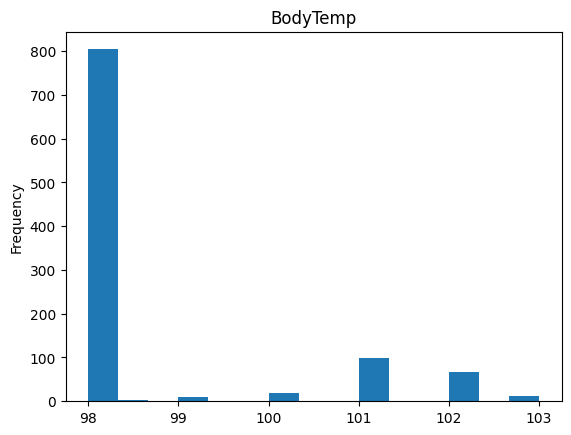

In [ ]:
df['BodyTemp'].plot(kind='hist', bins=15, title='BodyTemp');

Температура в градусах Цельсия - от 37 до 40. Для поступающих в больницу женщин вполне ожидаемый диапазон.

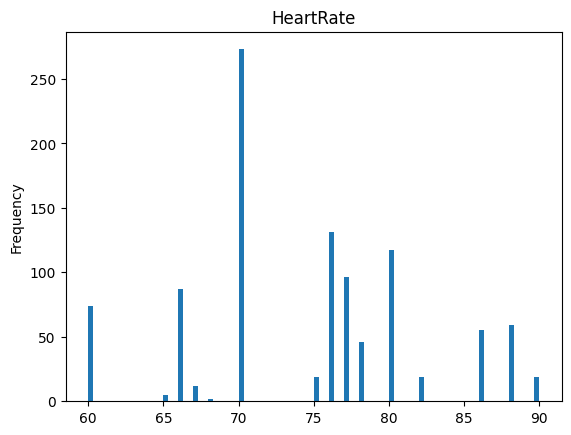

In [ ]:
df['HeartRate'].plot(kind='hist', bins=90, title='HeartRate');

Пульс 7 - явный выброс. Мода для всего набора данных - 70.

In [ ]:
df[df['HeartRate']==7]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,98.0,7,low risk
908,16,120,75,7.9,98.0,7,low risk


In [ ]:
df[(df['SystolicBP']==120) & (df['DiastolicBP']==75)]['HeartRate'].median()

70.0

Медиана пульса для давления 120 на 75: 70.  
Заменю выброс на медианный пульс.

In [ ]:
#df.loc[df['HeartRate']==7, 'HeartRate'] = 70
df['HeartRate'] = df['HeartRate'].replace(7, 70)

In [ ]:
#sns.histplot(data=df, x="HeartRate", hue="RiskLevel", kde=True, stat="probability", common_norm=False, element="step")

In [ ]:
#sns.pairplot(df, hue='RiskLevel')

 - Значения давления, глюкозы, температуры, пульса очень дискретны, поэтому это вероятно не дубликаты и удалять их не следует.
 - Исправлены аномалии в пульсе. Других аномалий не выявлено.
 - Пропусков в данных нет, типы данных корректные.

# Подготовка данных для модели

In [ ]:
#df без возраста 55 - 70
# df2 = df.drop(df[df['Age'] > 55].index)
# df2.shape

In [ ]:
#df без дубликатов
#df3 = df.drop_duplicates()
#df3.sort_values(by='Age')

Закодируем категориальные признаки.

In [ ]:
data = df

In [ ]:
X = data.drop('RiskLevel', axis=1)
y = data['RiskLevel']

In [ ]:
#pd.Series(y).value_counts()

In [ ]:
le = LabelEncoder()

le.fit(data['RiskLevel'])
le.classes_

y2 = le.transform(data['RiskLevel'])

Учебная и тестовая выборки:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(811, 6) (203, 6) (811,) (203,)


#Обучение моделей

In [ ]:
#Создам таблицу с метриками моделей
model = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier', 'CatBoostClassifier']
model_score = pd.DataFrame(columns=['score'], index=model)

##LogisticRegression

In [ ]:
scaler = StandardScaler()

logistic = LogisticRegression(max_iter=1000, tol=0.1, class_weight='balanced',
                        n_jobs=-1,
                        random_state=RANDOM_STATE)

pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

param_grid = {
    'logistic__max_iter' : [100, 300, 500],
    "logistic__C": [1, 10],
}
search = GridSearchCV(pipe, param_grid, cv=5)

search.fit(X_train, y_train)

print("Best score = %0.3f" % search.best_score_)
print('Best params: %s' % search.best_params_)

Best score = 0.625
Best params: {'logistic__C': 10, 'logistic__max_iter': 100}


## LogisticRegression with RandomTreesEmbedding

In [ ]:
from sklearn.ensemble import RandomTreesEmbedding

param_grid = {
    'randomtreesembedding__n_estimators' : np.arange(20, 60, 10),
    'randomtreesembedding__max_depth' : np.arange(3, 10),
    'logisticregression__max_iter' : [100],
    'logisticregression__C': [10],
}

rte = RandomTreesEmbedding(
    random_state=RANDOM_STATE
)

In [ ]:
rtl_model = make_pipeline(rte, logistic)
rtl_model.fit(X_train, y_train)

Pipeline(steps=[('randomtreesembedding',
                 RandomTreesEmbedding(random_state=4132)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1, random_state=4132, tol=0.1))])

In [ ]:
search_rtl = GridSearchCV(rtl_model, param_grid, cv=5)

search_rtl.fit(X_train, y_train)

print("Best score = %0.3f" % search_rtl.best_score_)
print('Best params: %s' % search_rtl.best_params_)

Best score = 0.822
Best params: {'logisticregression__C': 10, 'logisticregression__max_iter': 100, 'randomtreesembedding__max_depth': 8, 'randomtreesembedding__n_estimators': 40}


In [ ]:
model_score['score']['LogisticRegression'] = (search_rtl.best_score_).round(2)

##DecisionTreeClassifier

In [ ]:
dtclf = DecisionTreeClassifier(class_weight='balanced',
                                criterion='gini',
                                random_state=RANDOM_STATE)

param_grid = {
              'dtclf__max_depth': np.arange(5, 20)
              }

pipe_dtc = Pipeline(steps=[("scaler", scaler), ("dtclf", dtclf)])

search = GridSearchCV(pipe_dtc, param_grid, cv=5)

search.fit(X_train, y_train)

print("Best score = %0.3f" % search.best_score_)
print('Best params: %s' % search.best_params_)

Best score = 0.814
Best params: {'dtclf__max_depth': 16}


In [ ]:
model_score['score']['DecisionTreeClassifier'] = (search.best_score_).round(2)

## RandomForestClassifier

In [ ]:
rfclf = RandomForestClassifier(class_weight='balanced', criterion = 'gini', random_state=RANDOM_STATE)

param_grid = {'rfclf__n_estimators' : np.arange(40, 90, 10),
              'rfclf__max_depth': np.arange(10, 14)
              #'max_features': ['auto', 'sqrt'],
              #'min_samples_leaf': [1, 2, 4],
              #'min_samples_split': [2, 5, 10]
             }

pipe_rf = Pipeline(steps=[("scaler", scaler), ("rfclf", rfclf)])

search_rf = GridSearchCV(pipe_rf, param_grid,
                      cv=5, n_jobs=-1,
                      verbose=2)

search_rf.fit(X_train, y_train)

print("Best score = %0.3f" % search_rf.best_score_)
print('Best params: %s' % search_rf.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best score = 0.821
Best params: {'rfclf__max_depth': 11, 'rfclf__n_estimators': 60}


In [ ]:
model_score['score']['RandomForestClassifier'] = (search_rf.best_score_).round(2)

## GradientBoostingClassifier with RandomTreesEmbedding

In [ ]:
gb = GradientBoostingClassifier(learning_rate=0.1, #n_estimators = 80,
    random_state=RANDOM_STATE
)

rtegb_model = make_pipeline(rte, gb)

rtegb_model.fit(X_train, y_train)

Pipeline(steps=[('randomtreesembedding',
                 RandomTreesEmbedding(random_state=4132)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=4132))])

In [ ]:
param_grid_gb = {
    'randomtreesembedding__n_estimators' : np.arange(50, 80, 10),
    'randomtreesembedding__max_depth' : np.arange(3, 9),
    'gradientboostingclassifier__n_estimators' : [80]
}

search_gbc = GridSearchCV(rtegb_model, param_grid_gb,
                      cv=5, n_jobs=-1,
                      verbose=2)

search_gbc.fit(X_train, y_train)

print("Best score = %0.3f" % search_gbc.best_score_)
print('Best params: %s' % search_gbc.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best score = 0.809
Best params: {'gradientboostingclassifier__n_estimators': 80, 'randomtreesembedding__max_depth': 7, 'randomtreesembedding__n_estimators': 70}


In [ ]:
model_score['score']['GradientBoostingClassifier'] = (search_gbc.best_score_).round(2)

## CatBoostClassifier

In [ ]:
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'eval_metric': 'Accuracy',
    'random_seed': RANDOM_STATE,
    'logging_level': 'Silent',
    'leaf_estimation_method' : 'Newton',
    'loss_function' : 'MultiClass'
}

cbclf = CatBoostClassifier(**params)

cbclf.fit(X_train, y_train)
print("Best score: %s" % cbclf.best_score_)

Best score: {'learn': {'Accuracy': 0.9272503082614056, 'MultiClass': 0.17925300546525874}}


In [ ]:
model_score['score']['CatBoostClassifier'] = round(cbclf.best_score_['learn']['Accuracy'], 2)

##Таблица метрик качества моделей на тренировочной выборке

In [ ]:
model_score

,score
LogisticRegression,0.82
DecisionTreeClassifier,0.81
RandomForestClassifier,0.83
GradientBoostingClassifier,0.81
CatBoostClassifier,0.93


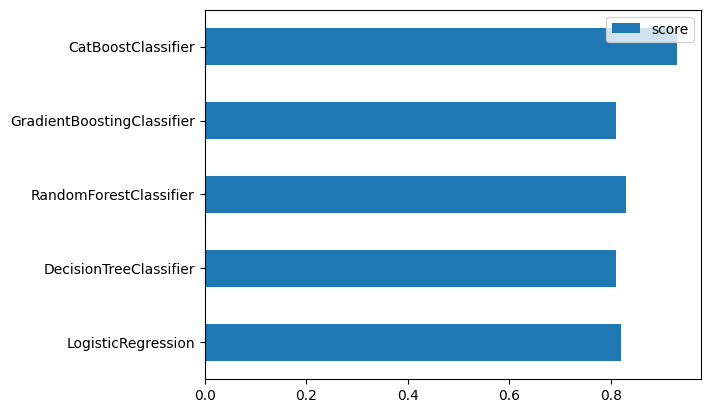

In [ ]:
model_score.plot.barh(y='score');

# Оценка качества предсказания лучшей модели на тестовой выборке

Лучшая точность получилась у CatBoostClassifier, оценим её на тестовой выборке.

In [ ]:
y_pred_cb = cbclf.predict(X_test)

print(classification_report(y_test, y_pred_cb))

              precision    recall  f1-score   support

   high risk       0.91      0.87      0.89        55
    low risk       0.81      0.85      0.83        81
    mid risk       0.80      0.78      0.79        67

    accuracy                           0.83       203
   macro avg       0.84      0.83      0.84       203
weighted avg       0.83      0.83      0.83       203



##Матрица ошибок на тестовой выборке

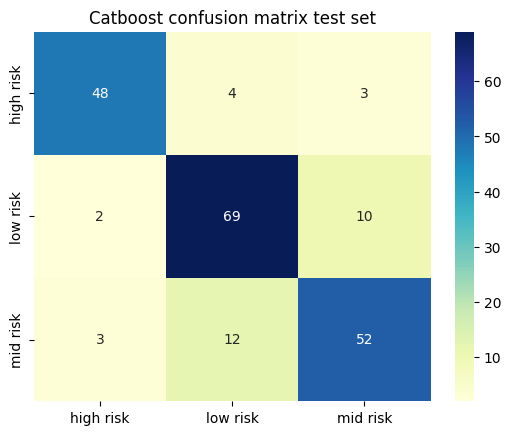

In [ ]:
labels = np.unique(y_pred_cb)
sns.heatmap(confusion_matrix(y_test, y_pred_cb), annot=True, xticklabels=labels, yticklabels=labels, fmt='g', cmap="YlGnBu");
plt.title('Catboost confusion matrix test set');

## Матрица ошибок на тренировочной выборке

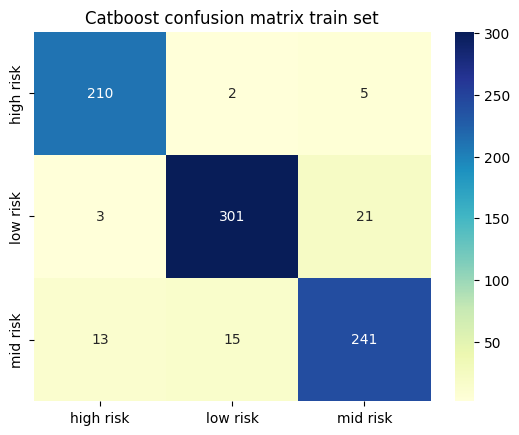

In [ ]:
sns.heatmap(confusion_matrix(y_train, cbclf.predict(X_train)), annot=True, xticklabels=labels, yticklabels=labels, fmt='g', cmap="YlGnBu");
plt.title('Catboost confusion matrix train set');

## Важность признаков.

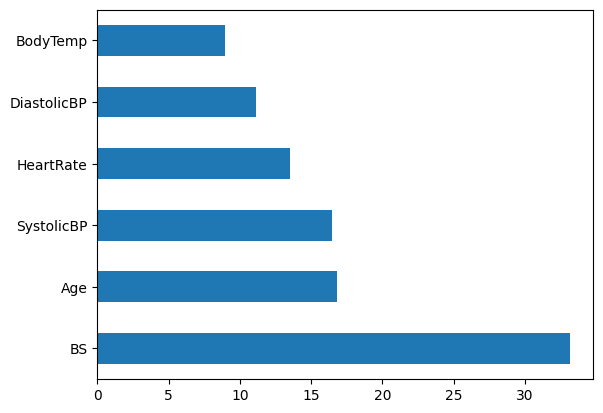

In [ ]:
feat_importances = pd.Series(cbclf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh');

# Выводы

* Наилучшую точность показала модель CatBoostClassifier - 83%.
* Наибольшее влияние на риск оказывает уровень глюкозы, наименьшее - температура для модели CatBoostClassifier.
* Согласно статье, с помощью алгоритма группы деревьев LMT (logistic model tree) можно получить самую высокую точность (почти 98%). Можно реализовать этот алгоритм, если нужна более высокая точность.
https://www.researchgate.net/publication/340106910_Review_and_Analysis_of_Risk_Factor_of_Maternal_Health_in_Remote_Area_Using_the_Internet_of_Things_IoT